In [47]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import tensorflow.keras.layers as tfl

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation

In [4]:
BATCH_SIZE = 64
IMG_SIZE = (160, 160)
directory = "/kaggle/input/pizza-not-pizza/pizza_not_pizza/"
train_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='training',
                                             seed=42)
validation_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='validation',
                                             seed=42)

Found 1966 files belonging to 2 classes.
Using 1573 files for training.
Found 1966 files belonging to 2 classes.
Using 393 files for validation.


2022-08-18 08:31:10.718781: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


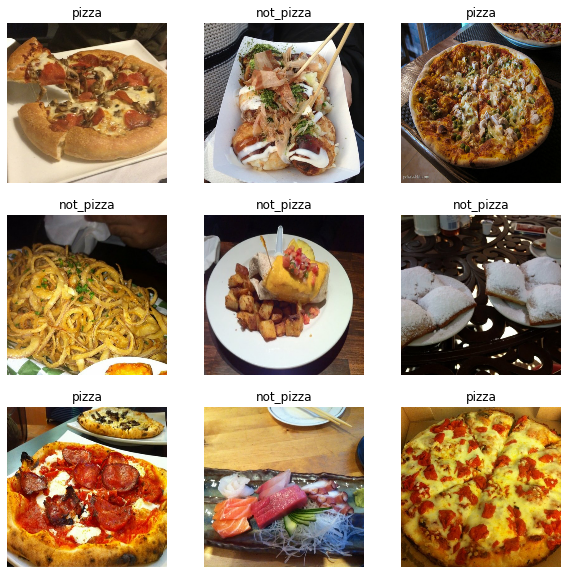

In [5]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [6]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

In [11]:
def data_augmenter():
    '''
    Create a Sequential model composed of 2 layers
    Returns:
        tf.keras.Sequential
    '''
    model = tf.keras.models.Sequential([
        RandomFlip('horizontal'),
        RandomRotation(0.2)
    ])
    
    return model

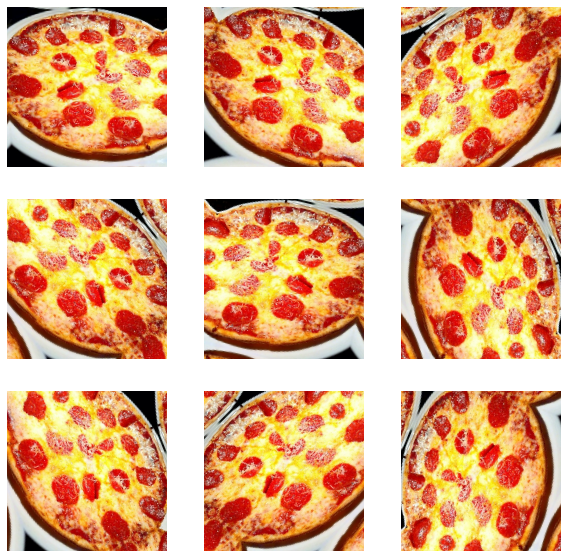

In [12]:
data_augmentation = data_augmenter()

for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

In [13]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

# Transfer learning with Mobilenet V2

In [27]:
def pizza_model(image_shape=IMG_SIZE, data_augmentation=data_augmenter()):
    ''' Define a tf.keras model for binary classification out of the MobileNetV2 model
    Arguments:
        image_shape -- Image width and height
        data_augmentation -- data augmentation function
    Returns:
    Returns:
        tf.keras.model
    '''
    
    
    input_shape = image_shape + (3,)
    
    base_model = tf.keras.applications.mobilenet_v2.MobileNetV2(
    input_shape=input_shape,
    include_top=False,
    weights='imagenet'
    )
    
    base_model.trainable = False
    inputs = tf.keras.Input(input_shape)
    X = data_augmentation(inputs)
    
    X = preprocess_input(X)
    X = base_model(X, training=False)
    
    X = tfl.GlobalAveragePooling2D()(X)
    X = tfl.Dropout(0.2)(X)
    
    prediction_layer = tfl.Dense(1)
    
    outputs = prediction_layer(X) 
    model = tf.keras.Model(inputs, outputs)
    return model

In [30]:
model = pizza_model(IMG_SIZE, data_augmentation)

In [31]:
base_learning_rate = 0.01
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [33]:
initial_epochs = 5
history = model.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs)

Epoch 1/5
25/25 [==============================] - 17s 535ms/step - loss: 0.2910 - accuracy: 0.8856 - val_loss: 0.2022 - val_accuracy: 0.9389
Epoch 2/5
25/25 [==============================] - 13s 492ms/step - loss: 0.2080 - accuracy: 0.9275 - val_loss: 0.1269 - val_accuracy: 0.9517
Epoch 3/5
25/25 [==============================] - 14s 539ms/step - loss: 0.1651 - accuracy: 0.9332 - val_loss: 0.1222 - val_accuracy: 0.9491
Epoch 4/5
25/25 [==============================] - 13s 512ms/step - loss: 0.1454 - accuracy: 0.9447 - val_loss: 0.1251 - val_accuracy: 0.9542
Epoch 5/5
25/25 [==============================] - 14s 509ms/step - loss: 0.1727 - accuracy: 0.9383 - val_loss: 0.1331 - val_accuracy: 0.9491


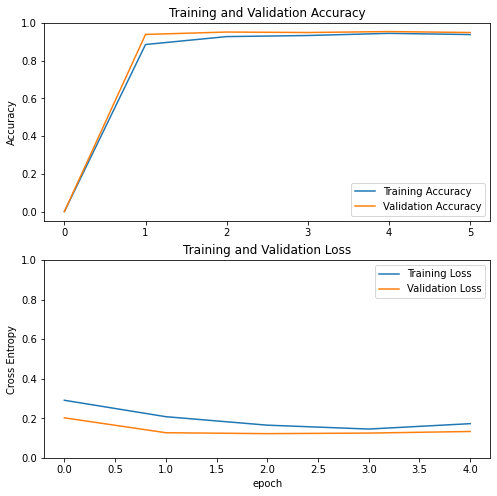

In [34]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [37]:
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv_3 (TFOpLambd (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract_3 (TFOpLamb (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_3 ( (None, 1280)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 1280)              0   

## Check predictions with strudel 

In [48]:
food_url = "../input/test2/strudel.jpg"
food_path = tf.keras.utils.get_file('strudel', origin=food_url)

img = tf.keras.utils.load_img(
    food_url, target_size = IMG_SIZE
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to not_pizza with a 100.00 percent confidence.
